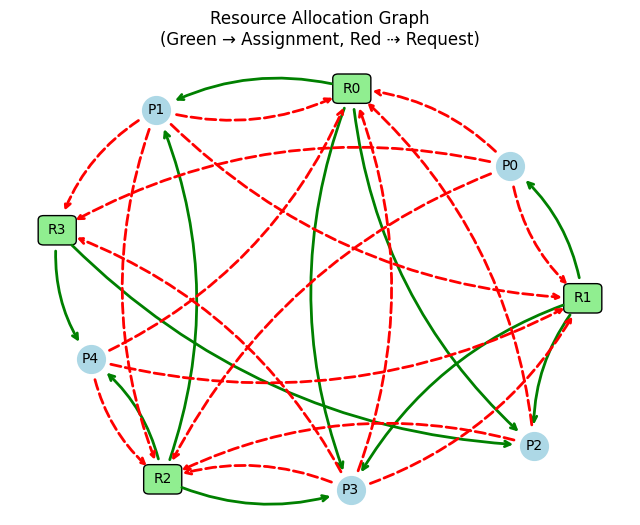

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class DeadlockVisualizer:
    def __init__(self, root):
        self.root = root
        self.root.title("Deadlock Detection & Recovery")

        self.canvas_frame = ttk.Frame(root)
        self.canvas_frame.pack(fill=tk.BOTH, expand=True)

        self.canvas = tk.Canvas(self.canvas_frame)
        self.scrollbar = ttk.Scrollbar(self.canvas_frame, orient=tk.VERTICAL, command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        self.inner_frame = ttk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.inner_frame, anchor="nw")
        self.inner_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))

        self.setup_widgets()

    def setup_widgets(self):
        self.default_allocation = [
            [0, 1, 0, 0],
            [2, 0, 1, 0],
            [3, 3, 0, 1],
            [2, 1, 1, 0],
            [0, 0, 2, 1]
        ]
        self.default_max = [
            [7, 5, 3, 2],
            [3, 2, 2, 2],
            [9, 0, 4, 0],
            [4, 2, 2, 1],
            [5, 3, 3, 1]
        ]
        self.default_available = [0, 0, 0, 0]

        self.matrix_frame = ttk.LabelFrame(self.inner_frame, text="Matrices")
        self.matrix_frame.pack(padx=10, pady=10)

        # Allocation Matrix
        tk.Label(self.matrix_frame, text="Allocation Matrix", font=("Arial", 10, "bold"), fg="blue").grid(row=0, column=0, columnspan=4, pady=(10, 0))
        self.alloc_entries = []
        for i, row in enumerate(self.default_allocation):
            row_entries = []
            for j, val in enumerate(row):
                e = tk.Entry(self.matrix_frame, width=5, justify='center')
                e.insert(0, str(val))
                e.grid(row=i + 1, column=j)
                row_entries.append(e)
            self.alloc_entries.append(row_entries)

        # Max Matrix
        tk.Label(self.matrix_frame, text="Max Matrix", font=("Arial", 10, "bold"), fg="blue").grid(row=0, column=5, columnspan=4, pady=(10, 0))
        self.max_entries = []
        for i, row in enumerate(self.default_max):
            row_entries = []
            for j, val in enumerate(row):
                e = tk.Entry(self.matrix_frame, width=5, justify='center')
                e.insert(0, str(val))
                e.grid(row=i + 1, column=j + 5)
                row_entries.append(e)
            self.max_entries.append(row_entries)

        # Available
        tk.Label(self.matrix_frame, text="Available Resources", font=("Arial", 10, "bold"), fg="blue").grid(row=7, column=0, columnspan=4, pady=(10, 0))
        self.available_entries = []
        for j, val in enumerate(self.default_available):
            e = tk.Entry(self.matrix_frame, width=5, justify='center')
            e.insert(0, str(val))
            e.grid(row=8, column=j)
            self.available_entries.append(e)

        # Action Buttons
        self.button_frame = ttk.Frame(self.inner_frame)
        self.button_frame.pack(pady=10)

        ttk.Button(self.button_frame, text="Check Safe State", command=self.check_safe_state).pack(side=tk.LEFT, padx=5)
        ttk.Button(self.button_frame, text="Show RAG", command=self.show_rag).pack(side=tk.LEFT, padx=5)
        ttk.Button(self.button_frame, text="Recover from Deadlock", command=self.recover_deadlock).pack(side=tk.LEFT, padx=5)

    def get_matrix(self, entries):
        return np.array([[int(cell.get()) for cell in row] for row in entries])

    def get_available(self):
        return [int(e.get()) for e in self.available_entries]

    def check_safe_state(self):
        alloc = self.get_matrix(self.alloc_entries)
        max_need = self.get_matrix(self.max_entries)
        available = self.get_available()

        need = max_need - alloc
        finish = [False] * len(alloc)
        work = available[:]
        safe_seq = []

        while True:
            found = False
            for i in range(len(alloc)):
                if not finish[i] and all(need[i][j] <= work[j] for j in range(len(work))):
                    for j in range(len(work)):
                        work[j] += alloc[i][j]
                    finish[i] = True
                    safe_seq.append(f"P{i}")
                    found = True
            if not found:
                break

        if all(finish):
            messagebox.showinfo("Safe State", f"System is in a safe state.\nSafe sequence: {', '.join(safe_seq)}")
        else:
            messagebox.showwarning("Deadlock", "System is not in a safe state! Deadlock may occur.")

    def show_rag(self):
        import matplotlib.patches as mpatches
        G = nx.DiGraph()
        alloc = self.get_matrix(self.alloc_entries)
        max_need = self.get_matrix(self.max_entries)
        available = self.get_available()
        num_resources = len(available)
        num_processes = len(alloc)

        for j in range(num_resources):
            G.add_node(f"R{j}", type='resource')
        for i in range(num_processes):
            G.add_node(f"P{i}", type='process')

        assignment_edges = []
        request_edges = []

        need = max_need - alloc

        for i in range(num_processes):
            for j in range(num_resources):
                if alloc[i][j] > 0:
                    assignment_edges.append((f"R{j}", f"P{i}"))
                if need[i][j] > 0:
                    request_edges.append((f"P{i}", f"R{j}"))

        fig, ax = plt.subplots(figsize=(8, 6))
        pos = nx.spring_layout(G, seed=42)

        # Draw nodes manually with different shapes
        for node, (x, y) in pos.items():
            if G.nodes[node]['type'] == 'process':
                ax.plot(x, y, 'o', markersize=20, color='lightblue')  # Circle
            else:
                rect = mpatches.FancyBboxPatch((x - 0.05, y - 0.05), 0.1, 0.1,
                                            boxstyle="round,pad=0.02",
                                            linewidth=1, edgecolor='black', facecolor='lightgreen')
                ax.add_patch(rect)
                ax.text(x, y, node, ha='center', va='center', fontsize=10, zorder=10)
                continue
            ax.text(x, y, node, ha='center', va='center', fontsize=10, zorder=10)

    # Draw edges manually with arrows
        def draw_edges(edges, color, style):
            for u, v in edges:
                ax.annotate("",
                            xy=pos[v], xycoords='data',
                            xytext=pos[u], textcoords='data',
                            arrowprops=dict(arrowstyle="->", color=color, linestyle=style, lw=2,
                                            shrinkA=15, shrinkB=15,
                                            connectionstyle="arc3,rad=0.2"),
                            )

        draw_edges(assignment_edges, "green", "solid")
        draw_edges(request_edges, "red", "dashed")

        ax.set_title("Resource Allocation Graph\n(Green → Assignment, Red ⇢ Request)")
        ax.axis('off')

        top = tk.Toplevel(self.root)
        top.title("Resource Allocation Graph")
        canvas = FigureCanvasTkAgg(fig, master=top)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def recover_deadlock(self):
        alloc = self.get_matrix(self.alloc_entries)
        max_need = self.get_matrix(self.max_entries)
        available = self.get_available()

        alloc = alloc.tolist()
        max_need = max_need.tolist()

        need = [[max_need[i][j] - alloc[i][j] for j in range(len(available))] for i in range(len(alloc))]
        finish = [False] * len(alloc)
        work = available[:]
        safe_seq = []
        preempted = []

        def is_safe(alloc, need, work, finish):
            temp_finish = finish[:]
            temp_work = work[:]
            temp_seq = []

            while True:
                found = False
                for i in range(len(alloc)):
                    if not temp_finish[i] and all(need[i][j] <= temp_work[j] for j in range(len(work))):
                        for j in range(len(work)):
                            temp_work[j] += alloc[i][j]
                        temp_finish[i] = True
                        temp_seq.append(f"P{i}")
                        found = True
                if not found:
                    break
            return all(temp_finish), temp_seq

        safe, safe_seq = is_safe(alloc, need, work, finish)
        if safe:
            messagebox.showinfo("Safe State", f"System is already in a safe state.\nSafe sequence: {', '.join(safe_seq)}")
            return

        # Preempt processes one by one until system is safe
        for i in range(len(alloc)):
            if not finish[i]:
                preempted.append(f"P{i}")
                for j in range(len(work)):
                    work[j] += alloc[i][j]
                alloc[i] = [0] * len(work)
                need[i] = [0] * len(work)
                finish[i] = True

                safe, safe_seq = is_safe(alloc, need, work, finish)
                if safe:
                    break

        if safe:
            messagebox.showinfo(
                "Deadlock Recovered",
                f"System was not in a safe state.\nPreempted processes: {', '.join(preempted)}\nNew Safe Sequence: {', '.join(safe_seq)}"
            )
        else:
            messagebox.showerror("Recovery Failed", "Could not recover the system to a safe state even after preempting all processes.")





if __name__ == "__main__":
    root = tk.Tk()
    app = DeadlockVisualizer(root)
    root.mainloop()
